In [4]:
import numpy as np
import h5py
import tqdm
import copy
import torch
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
import csv
import argparse
import seaborn as sns

sys.path.append('../')
from utils.misc import args_parser, average_weights
from utils.misc import get_data, process_isolated 
from utils.misc import time_slide_df, restart_index
from utils.models import LSTM
from models import Informer, Autoformer, Transformer, DLinear, Linear, NLinear

from utils.fed_update import LocalUpdate, test_inference, test_inference_new
from sklearn import metrics
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
args = argparse.Namespace(
    close_size = 3,
    period_size = 3,
    out_dim = 1,
    test_days = 7,
    val_days = 0,
    seed = 1,
    bs = 100,
    frac = 0.1,
    fedsgd = 1,
    local_bs = 20,
    epochs = 10,
    file = "milano.h5",
    type = "net"
)



In [6]:
normalized_df, selected_cells_df, selected_cells, mean, std, cell_lng, cell_lat, ori_df = get_data(args)


In [32]:
corre = ori_df.corr()



In [33]:
corre

1         2         3         4         5         6         7      \
1      1.000000  0.999981  0.999918  0.999831  0.999719  0.999918  0.999918   
2      0.999981  1.000000  0.999978  0.999697  0.999654  0.999978  0.999978   
3      0.999918  0.999978  1.000000  0.999514  0.999543  1.000000  1.000000   
4      0.999831  0.999697  0.999514  1.000000  0.999687  0.999514  0.999514   
5      0.999719  0.999654  0.999543  0.999687  1.000000  0.999543  0.999543   
...         ...       ...       ...       ...       ...       ...       ...   
9996   0.808904  0.809564  0.810225  0.806776  0.812923  0.810225  0.810225   
9997   0.802446  0.803049  0.803651  0.800485  0.805804  0.803651  0.803651   
9998   0.807586  0.808193  0.808800  0.805612  0.811090  0.808800  0.808800   
9999   0.772684  0.773639  0.774612  0.769694  0.777028  0.774612  0.774612   
10000  0.644972  0.646499  0.648080  0.640322  0.648415  0.648080  0.648080   

          8         9         10     ...     9991      9992      9993   \
1      0.999918  0.999918  0.975668  ...  0.766436  0.744997  0.478804   
2      0.999978  0.999978  0.976583  ...  0.767419  0.746376  0.480693   
3      1.000000  1.000000  0.977508  ...  0.768422  0.747797  0.482664   
4      0.999514  0.999514  0.972745  ...  0.763364  0.740762  0.473121   
5      0.999543  0.999543  0.977875  ...  0.769151  0.747793  0.481085   
...         ...       ...       ...  ...       ...       ...       ...   
9996   0.810225  0.810225  0.841389  ...  0.759369  0.784684  0.618124   
9997   0.803651  0.803651  0.828539  ...  0.736305  0.744665  0.550306   
9998   0.808800  0.808800  0.834742  ...  0.743486  0.754213  0.562569   
9999   0.774612  0.774612  0.817863  ...  0.768414  0.811954  0.679848   
10000  0.648080  0.648080  0.705155  ...  0.710401  0.772632  0.695023   

          9994      9995      9996      9997      9998      9999      10000  
1      0.476917  0.726353  0.808904  0.802446  0.807586  0.772684  0.644972  
2      0.478685  0.727587  0.809564  0.803049  0.808193  0.773639  0.646499  
3      0.480530  0.728857  0.810225  0.803651  0.808800  0.774612  0.648080  
4      0.471589  0.722547  0.806776  0.800485  0.805612  0.769694  0.640322  
5      0.479251  0.730288  0.812923  0.805804  0.811090  0.777028  0.648415  
...         ...       ...       ...       ...       ...       ...       ...  
9996   0.613129  0.921349  1.000000  0.969674  0.980029  0.955566  0.763450  
9997   0.547587  0.841333  0.969674  1.000000  0.998897  0.877671  0.715893  
9998   0.559408  0.859184  0.980029  0.998897  1.000000  0.896394  0.727133  
9999   0.671282  0.943770  0.955566  0.877671  0.896394  1.000000  0.886161  
10000  0.682536  0.810100  0.763450  0.715893  0.727133  0.886161  1.000000  

[9953 rows x 9953 columns]

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (121).

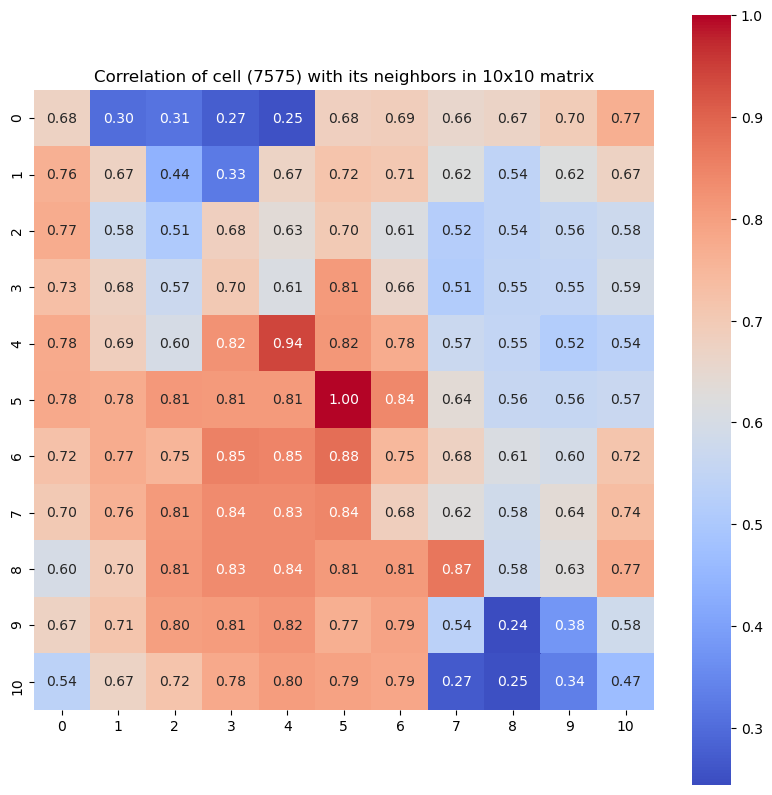

In [61]:
# 대상 셀의 ID 지정
target_cell_id = 7575  # 예시 값

# 한 행에 몇 개의 셀이 있는지
cells_per_row = 100

# target_cell의 좌표 (i,j) 계산
i, j = divmod(target_cell_id - 1, cells_per_row)
i += 1
j += 1

# 주변 셀들의 위치 계산 (11x11 행렬)
neighbors = [(i + di, j + dj) for di in range(-5, 6) for dj in range(-5, 6)]
neighbors_ids = [(x - 1) * cells_per_row + y for x, y in neighbors]
neighbors_labels = [str(cell_id) for cell_id in neighbors_ids if cell_id in ori_df.columns]


# ori_df에 존재하는 컬럼만 골라냄
valid_ids = [cell_id for cell_id in neighbors_ids if cell_id in ori_df.columns]

# 대상 셀과 주변 셀들과의 상관관계 계산
correlations = ori_df.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            correlation_matrix[dx + 5, dy + 5] = correlations.get(cell_id, np.nan)

# 히트맵 그리기
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title(f'Correlation of cell ({target_cell_id}) with its neighbors in 10x10 matrix')

# x, y축 라벨을 실제 cell ID로 변경
ax.set_xticklabels(neighbors_labels, rotation=90)
ax.set_yticklabels(reversed(neighbors_labels), rotation=0)

plt.show()

# correlation_matrix를 NumPy 배열로 저장
np.save('correlation_matrix.npy', correlation_matrix)

# 히트맵을 이미지로 저장
plt.savefig(f'cell:{target_cell_id}_corrleation_heatmap.png')

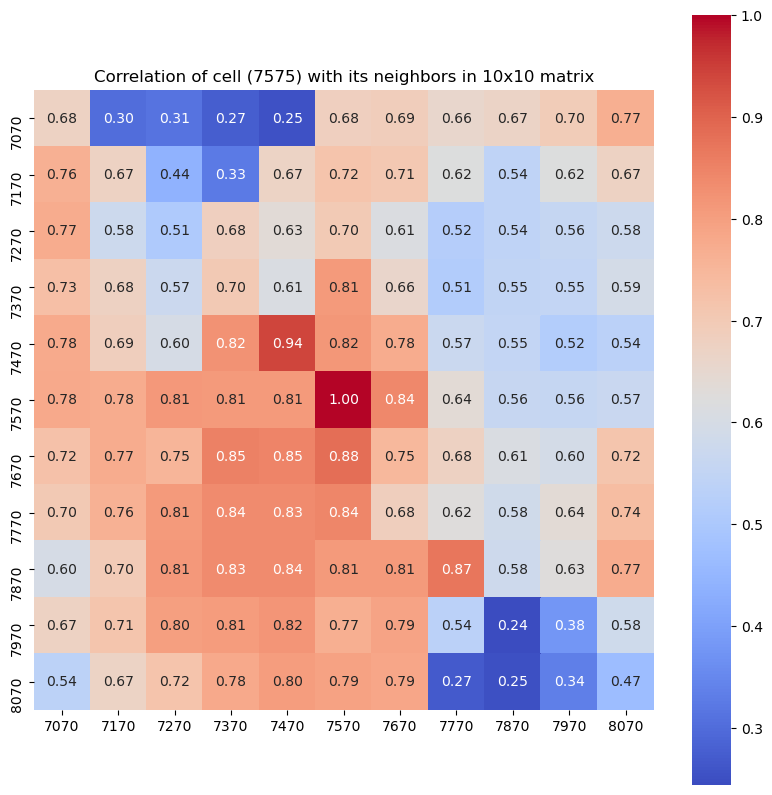

In [69]:
# 대상 셀과 주변 셀들의 상관 관계 계산 등

# 히트맵 그리기
plt.figure(figsize=(10, 10))

# 이웃 셀들의 실제 cell ID 값을 tick 레이블로 사용
xticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]
yticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            xticklabels=xticklabels, yticklabels=yticklabels)

plt.title(f'Correlation of cell ({target_cell_id}) with its neighbors in 10x10 matrix')

# 히트맵과 상관계수 행렬 저장
plt.savefig(f'cell:{target_cell_id}_original_corrleation_heatmap.png')
np.save(f'cell:{target_cell_id}_original_correlation_matrix.npy', correlation_matrix)

plt.show()

In [56]:
# Decomposition Visualization

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# 빈 데이터프레임 생성
decomposed_trend = pd.DataFrame(index=ori_df.index)
decomposed_seasonal = pd.DataFrame(index=ori_df.index)

# 각 열(column)에 대한 분해(decomposition) 수행
for column in ori_df.columns:
    series = ori_df[column]
    
    # 결측값이 있으면 처리
    series.dropna(inplace=True)

    # series가 너무 짧으면 분해할 수 없으므로 건너뜀
    if len(series) < 2:
        continue

    try:
        result = seasonal_decompose(series, model='additive', period=24)  # 주기는 데이터에 따라 조정해야 함
        decomposed_trend[column] = result.trend
        decomposed_seasonal[column] = result.seasonal
    except Exception as e:
        print(f"An exception occurred for column {column}: {e}")

print(decomposed_trend)
print(decomposed_seasonal)


/tmp/ipykernel_22473/681485157.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_22473/681485157.py:25: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_22473/681485157.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_22473/681485157.py:25: Performance

                     1      2      3      4      5      6      7      8      \
2013-11-04 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 03:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 04:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2013-12-29 19:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 20:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 21:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 22:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 23:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                     9      10     ...  9991   9992

/tmp/ipykernel_22473/681485157.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_22473/681485157.py:25: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_22473/681485157.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_22473/681485157.py:25: Performance

In [64]:
# 대상 셀과 주변 셀들과의 트렌드 상관관계 계산
trend_correlations = decomposed_trend.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
trend_correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            trend_correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            trend_correlation_matrix[dx + 5, dy + 5] = trend_correlations.get(cell_id, np.nan)

# 대상 셀과 주변 셀들과의 시즈널 상관관계 계산
seasonal_correlations = decomposed_seasonal.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
seasonal_correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            seasonal_correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            seasonal_correlation_matrix[dx + 5, dy + 5] = seasonal_correlations.get(cell_id, np.nan)

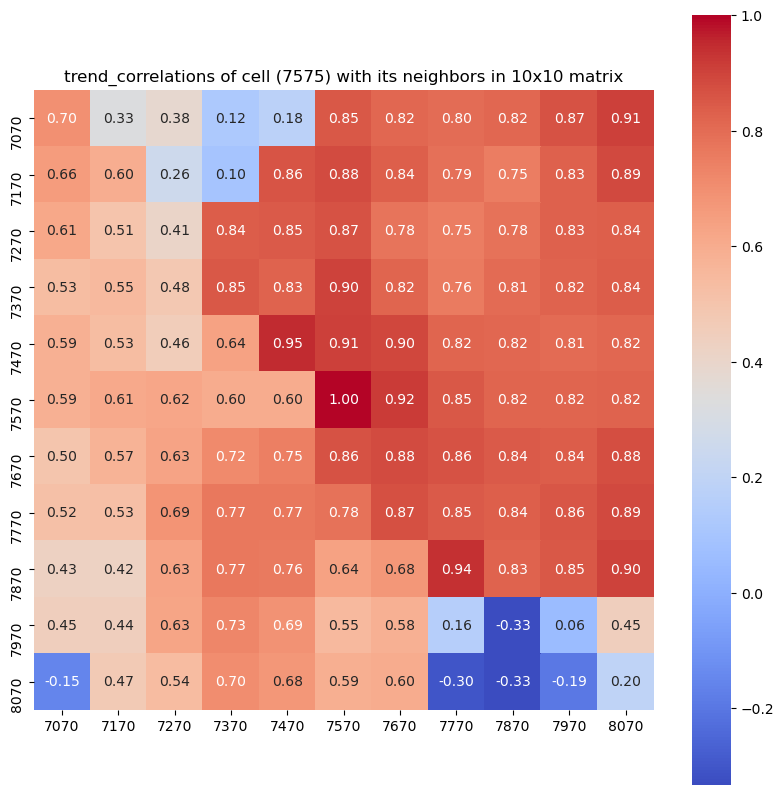

In [67]:

# 히트맵 그리기
plt.figure(figsize=(10,10))

# 이웃 셀들의 실제 cell ID 값을 tick 레이블로 사용
xticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]
yticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]

sns.heatmap(trend_correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            xticklabels=xticklabels, yticklabels=yticklabels)
plt.title(f'trend_correlations of cell ({target_cell_id}) with its neighbors in 10x10 matrix')
# 히트맵과 상관계수 행렬 저장
plt.savefig(f'cell:{target_cell_id}_trend_corrleation_heatmap.png')
np.save(f'cell:{target_cell_id}_trend_correlation_matrix.npy', trend_correlation_matrix)


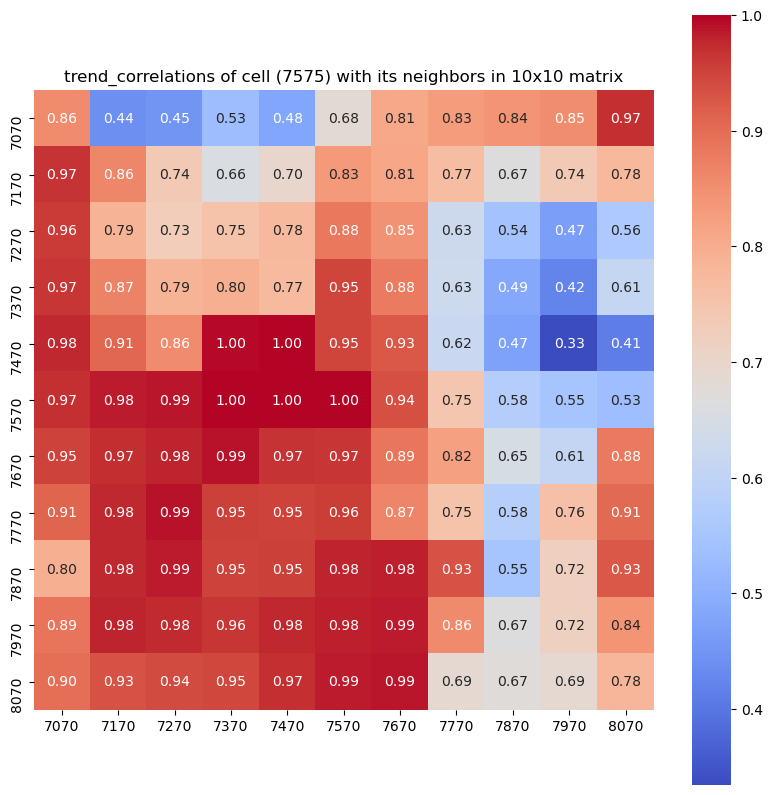

In [68]:

# 히트맵 그리기
plt.figure(figsize=(10,10))

# 이웃 셀들의 실제 cell ID 값을 tick 레이블로 사용
xticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]
yticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]

sns.heatmap(seasonal_correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            xticklabels=xticklabels, yticklabels=yticklabels)
plt.title(f'seasonal_corrleation of cell ({target_cell_id}) with its neighbors in 10x10 matrix')
# 히트맵과 상관계수 행렬 저장
plt.savefig(f'cell:{target_cell_id}_seasonal_corrleation_heatmap.png')
np.save(f'cell:{target_cell_id}_seasonal_correlation_matrix.npy', seasonal_correlation_matrix)

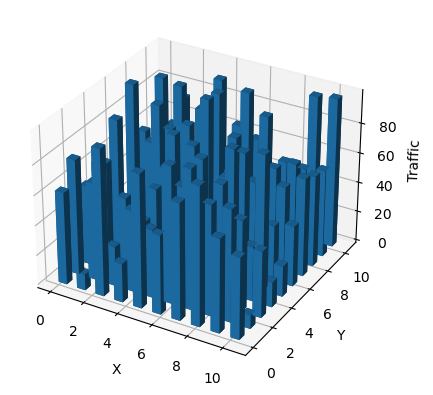

In [48]:
# 샘플 데이터 생성
x, y = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
z = np.random.rand(10, 10) * 100  # 트래픽 양을 임의로 생성

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 3D 막대 그래프 생성
ax.bar3d(x.flatten(), y.flatten(), np.zeros_like(z.flatten()), dx=0.5, dy=0.5, dz=z.flatten(), shade=True)

# 축 레이블 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Traffic')

plt.show()

In [51]:
import plotly.graph_objects as go
import numpy as np

# 샘플 데이터 생성
n = 10
x = np.tile(np.linspace(0, 10, n), n)
y = np.repeat(np.linspace(0, 10, n), n)
z = np.random.rand(n * n) * 100  # 트래픽 양을 임의로 생성

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# 축 레이블 설정
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Traffic'
))

fig.show()


In [22]:
selected_cells


[35,
 157,
 214,
 370,
 383,
 436,
 484,
 495,
 504,
 521,
 585,
 732,
 1053,
 1436,
 1557,
 1658,
 1694,
 1788,
 1951,
 2000,
 2221,
 2702,
 2782,
 2811,
 2854,
 3065,
 3130,
 3288,
 3459,
 3568,
 3604,
 3652,
 3738,
 3768,
 3802,
 3823,
 3838,
 3997,
 4199,
 4384,
 4691,
 4788,
 4897,
 5012,
 5097,
 5244,
 5498,
 5681,
 5711,
 5836,
 6062,
 6118,
 6187,
 6267,
 6293,
 6434,
 6491,
 6492,
 6496,
 6671,
 6674,
 6836,
 6866,
 6963,
 7138,
 7222,
 7239,
 7345,
 7412,
 7578,
 7737,
 7785,
 7916,
 8041,
 8071,
 8165,
 8171,
 8229,
 8253,
 8276,
 8326,
 8366,
 8378,
 8465,
 8583,
 8692,
 8889,
 8918,
 9031,
 9039,
 9106,
 9164,
 9373,
 9514,
 9520,
 9674,
 9698,
 9733,
 9766,
 10000]

In [23]:
def closest_pairs(nums):
    # 연속된 두 요소 간의 차이를 계산
    differences = [nums[i+1] - nums[i] for i in range(len(nums) - 1)]
    
    # 최소 차이 찾기
    min_diff = min(differences)

    # 최소 차이를 가지는 모든 숫자 쌍과 그들의 인덱스 찾기
    pairs_and_indices = [((nums[i], nums[i+1]), (i, i+1)) for i, diff in enumerate(differences) if diff == min_diff]

    return pairs_and_indices

In [24]:
print(closest_pairs(selected_cells))

[((6491, 6492), (56, 57))]


In [30]:
lng = cell_lng[56]
lat = cell_lat[56]
lng2 = cell_lng[57]
lat2 = cell_lat[57]

In [31]:
po1 = (lat,lng)
po2 = (lat2,lng2)
po2

(45.49276327547867, 9.286708683940935)

In [34]:
type(ori_df[6491])

pandas.core.series.Series

In [35]:
correlation = ori_df[6491].corr(ori_df[6492])

print(correlation)


0.5763223016791171


In [7]:
df,ori_df,df_s,_,_,_,_ = get_data("milano.h5")

AttributeError: 'str' object has no attribute 'file'

In [48]:
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'index': 'date_time'})

train_df = df_reset.iloc[:-24*7].copy()
test_df = df_reset.iloc[-24*7:].copy()
test_df = restart_index(test_df)

In [49]:
targets=1012

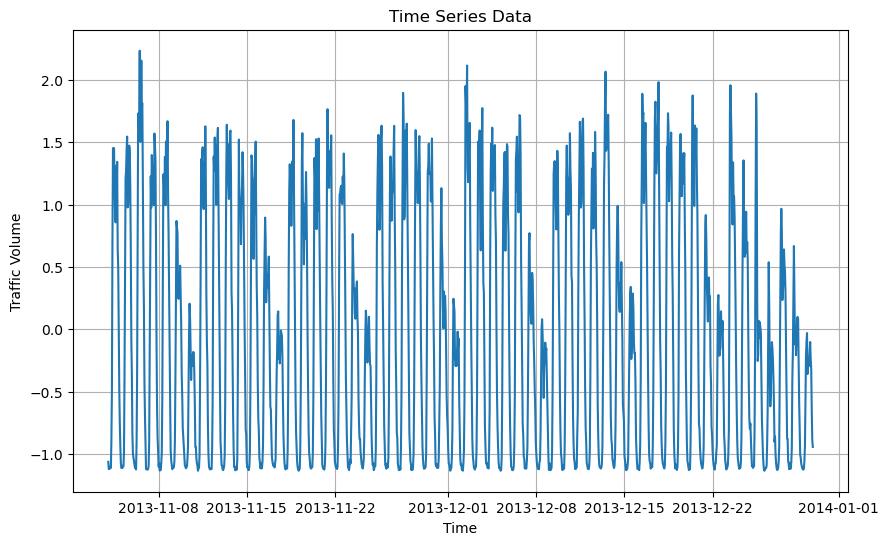

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df_reset['date_time'], df_reset[targets])
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('Time Series Data')
plt.grid(True)
plt.show()

In [60]:
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 3
batch_size = 20
targets = 1012
date = 'date_time'

#train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'date_time', targets)
#def time_slide_df(df, window_size, forcast_size, date, target):
    
train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)


In [61]:
train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)

valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

In [62]:

### DLinear 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  2%|█▎                                                                | 4/200 [00:00<00:10, 18.67it/s]

valid_loss=0.178, test_los0.156, Model Save
epoch = 1, train_loss : 0.357, valid_loss : 0.178, test_loss : 0.156
valid_loss=0.126, test_los0.132, Model Save
epoch = 2, train_loss : 0.166, valid_loss : 0.126, test_loss : 0.132
valid_loss=0.097, test_los0.116, Model Save
epoch = 3, train_loss : 0.130, valid_loss : 0.097, test_loss : 0.116
valid_loss=0.082, test_los0.106, Model Save
epoch = 4, train_loss : 0.112, valid_loss : 0.082, test_loss : 0.106


  4%|██▋                                                               | 8/200 [00:00<00:09, 19.34it/s]

valid_loss=0.079, test_los0.102, Model Save
epoch = 5, train_loss : 0.101, valid_loss : 0.079, test_loss : 0.102
epoch = 6, train_loss : 0.093, valid_loss : 0.081, test_loss : 0.106
valid_loss=0.071, test_los0.088, Model Save
epoch = 7, train_loss : 0.088, valid_loss : 0.071, test_loss : 0.088
valid_loss=0.066, test_los0.090, Model Save
epoch = 8, train_loss : 0.083, valid_loss : 0.066, test_loss : 0.090


  6%|███▉                                                             | 12/200 [00:00<00:09, 19.59it/s]

valid_loss=0.065, test_los0.076, Model Save
epoch = 9, train_loss : 0.079, valid_loss : 0.065, test_loss : 0.076
valid_loss=0.059, test_los0.078, Model Save
epoch = 10, train_loss : 0.078, valid_loss : 0.059, test_loss : 0.078
epoch = 11, train_loss : 0.076, valid_loss : 0.067, test_loss : 0.089
epoch = 12, train_loss : 0.074, valid_loss : 0.063, test_loss : 0.082


  8%|█████▏                                                           | 16/200 [00:00<00:09, 19.74it/s]

valid_loss=0.057, test_los0.077, Model Save
epoch = 13, train_loss : 0.072, valid_loss : 0.057, test_loss : 0.077
epoch = 14, train_loss : 0.071, valid_loss : 0.062, test_loss : 0.069
epoch = 15, train_loss : 0.070, valid_loss : 0.059, test_loss : 0.070
epoch = 16, train_loss : 0.069, valid_loss : 0.062, test_loss : 0.074
epoch = 17, train_loss : 0.068, valid_loss : 0.059, test_loss : 0.063


 10%|██████▌                                                          | 20/200 [00:01<00:09, 19.80it/s]

epoch = 18, train_loss : 0.067, valid_loss : 0.060, test_loss : 0.077
epoch = 19, train_loss : 0.067, valid_loss : 0.058, test_loss : 0.074
valid_loss=0.056, test_los0.078, Model Save
epoch = 20, train_loss : 0.067, valid_loss : 0.056, test_loss : 0.078
epoch = 21, train_loss : 0.066, valid_loss : 0.058, test_loss : 0.066


 12%|███████▊                                                         | 24/200 [00:01<00:08, 19.79it/s]

valid_loss=0.055, test_los0.066, Model Save
epoch = 22, train_loss : 0.065, valid_loss : 0.055, test_loss : 0.066
epoch = 23, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.065
valid_loss=0.054, test_los0.070, Model Save
epoch = 24, train_loss : 0.066, valid_loss : 0.054, test_loss : 0.070
epoch = 25, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.069


 14%|█████████                                                        | 28/200 [00:01<00:08, 19.87it/s]

epoch = 26, train_loss : 0.064, valid_loss : 0.062, test_loss : 0.079
epoch = 27, train_loss : 0.065, valid_loss : 0.057, test_loss : 0.065
epoch = 28, train_loss : 0.064, valid_loss : 0.057, test_loss : 0.064
epoch = 29, train_loss : 0.064, valid_loss : 0.058, test_loss : 0.061
valid_loss=0.053, test_los0.065, Model Save


 17%|███████████                                                      | 34/200 [00:01<00:08, 19.91it/s]

epoch = 30, train_loss : 0.064, valid_loss : 0.053, test_loss : 0.065
epoch = 31, train_loss : 0.063, valid_loss : 0.061, test_loss : 0.077
epoch = 32, train_loss : 0.063, valid_loss : 0.057, test_loss : 0.078
epoch = 33, train_loss : 0.063, valid_loss : 0.054, test_loss : 0.058
epoch = 34, train_loss : 0.063, valid_loss : 0.060, test_loss : 0.065


 19%|████████████▎                                                    | 38/200 [00:01<00:08, 19.89it/s]

epoch = 35, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.065
valid_loss=0.053, test_los0.061, Model Save
epoch = 36, train_loss : 0.063, valid_loss : 0.053, test_loss : 0.061
epoch = 37, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.068
epoch = 38, train_loss : 0.063, valid_loss : 0.054, test_loss : 0.066


 21%|█████████████▋                                                   | 42/200 [00:02<00:07, 19.90it/s]

epoch = 39, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.063
epoch = 40, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.067
epoch = 41, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.067
epoch = 42, train_loss : 0.063, valid_loss : 0.058, test_loss : 0.062
epoch = 43, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.066


 24%|███████████████▌                                                 | 48/200 [00:02<00:07, 19.91it/s]

epoch = 44, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.074
epoch = 45, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.063
epoch = 46, train_loss : 0.062, valid_loss : 0.060, test_loss : 0.063
epoch = 47, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.074
epoch = 48, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.069


 26%|████████████████▉                                                | 52/200 [00:02<00:07, 19.91it/s]

epoch = 49, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.057
epoch = 50, train_loss : 0.062, valid_loss : 0.054, test_loss : 0.065
epoch = 51, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.070
epoch = 52, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.073
epoch = 53, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.065


 28%|██████████████████▏                                              | 56/200 [00:02<00:07, 19.89it/s]

epoch = 54, train_loss : 0.062, valid_loss : 0.066, test_loss : 0.065
epoch = 55, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 56, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.069
epoch = 57, train_loss : 0.062, valid_loss : 0.059, test_loss : 0.062
epoch = 58, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.058


 31%|████████████████████▏                                            | 62/200 [00:03<00:06, 19.85it/s]

epoch = 59, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.064
epoch = 60, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.069
epoch = 61, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.066
epoch = 62, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.065


 33%|█████████████████████▍                                           | 66/200 [00:03<00:06, 19.83it/s]

epoch = 63, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.066
epoch = 64, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.072
epoch = 65, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.076
epoch = 66, train_loss : 0.061, valid_loss : 0.065, test_loss : 0.072


 35%|██████████████████████▊                                          | 70/200 [00:03<00:06, 19.82it/s]

epoch = 67, train_loss : 0.063, valid_loss : 0.067, test_loss : 0.070
epoch = 68, train_loss : 0.063, valid_loss : 0.057, test_loss : 0.075
epoch = 69, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.065
epoch = 70, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.080


 37%|████████████████████████                                         | 74/200 [00:03<00:06, 19.83it/s]

epoch = 71, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.077
epoch = 72, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.073
epoch = 73, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.072
epoch = 74, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.058


 39%|█████████████████████████▎                                       | 78/200 [00:03<00:06, 19.83it/s]

epoch = 75, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.065
epoch = 76, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.059
epoch = 77, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.064
epoch = 78, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.066


 41%|██████████████████████████▋                                      | 82/200 [00:04<00:05, 19.84it/s]

epoch = 79, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.068
epoch = 80, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.061
epoch = 81, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.077
epoch = 82, train_loss : 0.060, valid_loss : 0.062, test_loss : 0.076


 43%|███████████████████████████▉                                     | 86/200 [00:04<00:05, 19.85it/s]

epoch = 83, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.063
epoch = 84, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.065
epoch = 85, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.065
epoch = 86, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.068


 45%|█████████████████████████████▎                                   | 90/200 [00:04<00:05, 19.84it/s]

epoch = 87, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.072
epoch = 88, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.062
epoch = 89, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.058
epoch = 90, train_loss : 0.062, valid_loss : 0.054, test_loss : 0.060


 47%|██████████████████████████████▌                                  | 94/200 [00:04<00:05, 19.86it/s]

epoch = 91, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.064
epoch = 92, train_loss : 0.060, valid_loss : 0.062, test_loss : 0.071
epoch = 93, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066
epoch = 94, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.056


 49%|███████████████████████████████▊                                 | 98/200 [00:04<00:05, 19.88it/s]

epoch = 95, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.069
epoch = 96, train_loss : 0.061, valid_loss : 0.061, test_loss : 0.078
epoch = 97, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.067
epoch = 98, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.062
epoch = 99, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.059


 52%|█████████████████████████████████▎                              | 104/200 [00:05<00:04, 19.89it/s]

epoch = 100, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.073
epoch = 101, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.082
epoch = 102, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.061
epoch = 103, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.066
epoch = 104, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.075


 54%|██████████████████████████████████▌                             | 108/200 [00:05<00:04, 19.89it/s]

epoch = 105, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.065
epoch = 106, train_loss : 0.060, valid_loss : 0.067, test_loss : 0.082
epoch = 107, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 108, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.070


 56%|███████████████████████████████████▊                            | 112/200 [00:05<00:04, 19.90it/s]

epoch = 109, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.075
epoch = 110, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.066
epoch = 111, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.057
epoch = 112, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.071
epoch = 113, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.067


 59%|█████████████████████████████████████▊                          | 118/200 [00:05<00:04, 19.92it/s]

epoch = 114, train_loss : 0.060, valid_loss : 0.063, test_loss : 0.078
epoch = 115, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.055
epoch = 116, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.067
epoch = 117, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.066
epoch = 118, train_loss : 0.061, valid_loss : 0.070, test_loss : 0.082


 61%|███████████████████████████████████████                         | 122/200 [00:06<00:03, 19.92it/s]

epoch = 119, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.060
epoch = 120, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.067
epoch = 121, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.067
epoch = 122, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.071
epoch = 123, train_loss : 0.061, valid_loss : 0.062, test_loss : 0.069


 64%|████████████████████████████████████████▉                       | 128/200 [00:06<00:03, 19.92it/s]

epoch = 124, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.064
epoch = 125, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.061
epoch = 126, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.072
epoch = 127, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.063
epoch = 128, train_loss : 0.060, valid_loss : 0.065, test_loss : 0.079


 66%|██████████████████████████████████████████▏                     | 132/200 [00:06<00:03, 19.90it/s]

epoch = 129, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.069
epoch = 130, train_loss : 0.062, valid_loss : 0.061, test_loss : 0.063
epoch = 131, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.068
epoch = 132, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.065


 68%|███████████████████████████████████████████▌                    | 136/200 [00:06<00:03, 19.89it/s]

epoch = 133, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.063
epoch = 134, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.069
epoch = 135, train_loss : 0.061, valid_loss : 0.062, test_loss : 0.078
epoch = 136, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.069


 70%|████████████████████████████████████████████▊                   | 140/200 [00:07<00:03, 19.89it/s]

epoch = 137, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.063
epoch = 138, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.065
epoch = 139, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.079
epoch = 140, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.071


 72%|██████████████████████████████████████████████                  | 144/200 [00:07<00:02, 19.89it/s]

epoch = 141, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.078
epoch = 142, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 143, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.061
epoch = 144, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.059
epoch = 145, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.072


 74%|███████████████████████████████████████████████▎                | 148/200 [00:07<00:02, 19.85it/s]

epoch = 146, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.069
epoch = 147, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.066
epoch = 148, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.063
epoch = 149, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.074


 76%|████████████████████████████████████████████████▋               | 152/200 [00:07<00:02, 19.85it/s]

epoch = 150, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.069
epoch = 151, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.060
epoch = 152, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.071
epoch = 153, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.082


 78%|█████████████████████████████████████████████████▉              | 156/200 [00:07<00:02, 19.85it/s]

epoch = 154, train_loss : 0.059, valid_loss : 0.053, test_loss : 0.058
epoch = 155, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.064
epoch = 156, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.063
epoch = 157, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.065


 80%|███████████████████████████████████████████████████▏            | 160/200 [00:08<00:02, 19.86it/s]

epoch = 158, train_loss : 0.059, valid_loss : 0.062, test_loss : 0.072
epoch = 159, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.068
epoch = 160, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.075
epoch = 161, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.067


 82%|████████████████████████████████████████████████████▍           | 164/200 [00:08<00:01, 19.86it/s]

epoch = 162, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.065
epoch = 163, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.059
epoch = 164, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.059
valid_loss=0.053, test_los0.057, Model Save
epoch = 165, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.057


 84%|█████████████████████████████████████████████████████▊          | 168/200 [00:08<00:01, 19.83it/s]

epoch = 166, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.066
epoch = 167, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.058
epoch = 168, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.067
epoch = 169, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.071


 86%|███████████████████████████████████████████████████████         | 172/200 [00:08<00:01, 19.84it/s]

epoch = 170, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066
epoch = 171, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 172, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 173, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.069


 88%|████████████████████████████████████████████████████████▎       | 176/200 [00:08<00:01, 19.85it/s]

epoch = 174, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 175, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.059
epoch = 176, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.078
epoch = 177, train_loss : 0.060, valid_loss : 0.063, test_loss : 0.067


 90%|█████████████████████████████████████████████████████████▌      | 180/200 [00:09<00:01, 19.85it/s]

epoch = 178, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.067
epoch = 179, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.077
epoch = 180, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.057
epoch = 181, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.069


 92%|██████████████████████████████████████████████████████████▉     | 184/200 [00:09<00:00, 19.84it/s]

epoch = 182, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.069
epoch = 183, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.058
epoch = 184, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.070
epoch = 185, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.058


 94%|████████████████████████████████████████████████████████████▏   | 188/200 [00:09<00:00, 19.85it/s]

epoch = 186, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.066
epoch = 187, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.064
epoch = 188, train_loss : 0.060, valid_loss : 0.060, test_loss : 0.073
epoch = 189, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.064


 96%|█████████████████████████████████████████████████████████████▍  | 192/200 [00:09<00:00, 19.85it/s]

epoch = 190, train_loss : 0.061, valid_loss : 0.064, test_loss : 0.072
epoch = 191, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.059
epoch = 192, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.064
epoch = 193, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.064


 98%|██████████████████████████████████████████████████████████████▋ | 196/200 [00:09<00:00, 19.85it/s]

epoch = 194, train_loss : 0.061, valid_loss : 0.064, test_loss : 0.079
epoch = 195, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.075
epoch = 196, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.060
epoch = 197, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066


100%|████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.83it/s]

epoch = 198, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.059
epoch = 199, train_loss : 0.059, valid_loss : 0.055, test_loss : 0.066
epoch = 200, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.072


In [38]:
### Llinear모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
Linear_model = LTSF_Linear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Linear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    Linear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = Linear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    Linear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = Linear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = Linear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(Linear_model, 'Linear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        linear_best_epoch = epoch
        linear_best_train_loss = np.mean(loss_list)
        linear_best_valid_loss = np.mean(valid_loss.item())
        linear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|██▉                                                               | 9/200 [00:00<00:04, 43.78it/s]

valid_loss=0.329, test_los0.444, Model Save
epoch = 1, train_loss : 0.646, valid_loss : 0.329, test_loss : 0.444
valid_loss=0.264, test_los0.411, Model Save
epoch = 2, train_loss : 0.306, valid_loss : 0.264, test_loss : 0.411
valid_loss=0.239, test_los0.396, Model Save
epoch = 3, train_loss : 0.257, valid_loss : 0.239, test_loss : 0.396
valid_loss=0.220, test_los0.385, Model Save
epoch = 4, train_loss : 0.229, valid_loss : 0.220, test_loss : 0.385
valid_loss=0.213, test_los0.379, Model Save
epoch = 5, train_loss : 0.209, valid_loss : 0.213, test_loss : 0.379
valid_loss=0.201, test_los0.370, Model Save
epoch = 6, train_loss : 0.196, valid_loss : 0.201, test_loss : 0.370
valid_loss=0.197, test_los0.363, Model Save
epoch = 7, train_loss : 0.190, valid_loss : 0.197, test_loss : 0.363
valid_loss=0.194, test_los0.361, Model Save
epoch = 8, train_loss : 0.181, valid_loss : 0.194, test_loss : 0.361
epoch = 9, train_loss : 0.178, valid_loss : 0.198, test_loss : 0.352
valid_loss=0.185, test_los0

 10%|██████▏                                                          | 19/200 [00:00<00:03, 46.56it/s]

valid_loss=0.184, test_los0.348, Model Save
epoch = 11, train_loss : 0.173, valid_loss : 0.184, test_loss : 0.348
epoch = 12, train_loss : 0.168, valid_loss : 0.188, test_loss : 0.343
valid_loss=0.178, test_los0.337, Model Save
epoch = 13, train_loss : 0.167, valid_loss : 0.178, test_loss : 0.337
valid_loss=0.176, test_los0.335, Model Save
epoch = 14, train_loss : 0.165, valid_loss : 0.176, test_loss : 0.335
epoch = 15, train_loss : 0.164, valid_loss : 0.180, test_loss : 0.331
epoch = 16, train_loss : 0.161, valid_loss : 0.181, test_loss : 0.331
valid_loss=0.170, test_los0.327, Model Save
epoch = 17, train_loss : 0.163, valid_loss : 0.170, test_loss : 0.327
valid_loss=0.169, test_los0.327, Model Save
epoch = 18, train_loss : 0.159, valid_loss : 0.169, test_loss : 0.327
epoch = 19, train_loss : 0.158, valid_loss : 0.179, test_loss : 0.327
valid_loss=0.168, test_los0.325, Model Save
epoch = 20, train_loss : 0.157, valid_loss : 0.168, test_loss : 0.325


 14%|█████████▍                                                       | 29/200 [00:00<00:03, 47.48it/s]

epoch = 21, train_loss : 0.156, valid_loss : 0.171, test_loss : 0.319
valid_loss=0.166, test_los0.316, Model Save
epoch = 22, train_loss : 0.154, valid_loss : 0.166, test_loss : 0.316
epoch = 23, train_loss : 0.155, valid_loss : 0.177, test_loss : 0.317
epoch = 24, train_loss : 0.153, valid_loss : 0.167, test_loss : 0.319
valid_loss=0.163, test_los0.313, Model Save
epoch = 25, train_loss : 0.153, valid_loss : 0.163, test_loss : 0.313
epoch = 26, train_loss : 0.150, valid_loss : 0.177, test_loss : 0.316
epoch = 27, train_loss : 0.151, valid_loss : 0.165, test_loss : 0.317
valid_loss=0.159, test_los0.313, Model Save
epoch = 28, train_loss : 0.150, valid_loss : 0.159, test_loss : 0.313
epoch = 29, train_loss : 0.151, valid_loss : 0.171, test_loss : 0.310
epoch = 30, train_loss : 0.149, valid_loss : 0.166, test_loss : 0.311


 20%|████████████▋                                                    | 39/200 [00:00<00:03, 48.29it/s]

epoch = 31, train_loss : 0.148, valid_loss : 0.166, test_loss : 0.313
epoch = 32, train_loss : 0.150, valid_loss : 0.166, test_loss : 0.309
epoch = 33, train_loss : 0.148, valid_loss : 0.163, test_loss : 0.309
epoch = 34, train_loss : 0.148, valid_loss : 0.171, test_loss : 0.309
epoch = 35, train_loss : 0.148, valid_loss : 0.171, test_loss : 0.312
epoch = 36, train_loss : 0.145, valid_loss : 0.167, test_loss : 0.310
epoch = 37, train_loss : 0.146, valid_loss : 0.164, test_loss : 0.303
epoch = 38, train_loss : 0.145, valid_loss : 0.166, test_loss : 0.306
epoch = 39, train_loss : 0.146, valid_loss : 0.165, test_loss : 0.308
epoch = 40, train_loss : 0.146, valid_loss : 0.165, test_loss : 0.309


 24%|███████████████▉                                                 | 49/200 [00:01<00:03, 48.58it/s]

epoch = 41, train_loss : 0.145, valid_loss : 0.160, test_loss : 0.307
epoch = 42, train_loss : 0.144, valid_loss : 0.160, test_loss : 0.305
epoch = 43, train_loss : 0.144, valid_loss : 0.163, test_loss : 0.305
valid_loss=0.158, test_los0.304, Model Save
epoch = 44, train_loss : 0.143, valid_loss : 0.158, test_loss : 0.304
epoch = 45, train_loss : 0.145, valid_loss : 0.167, test_loss : 0.305
epoch = 46, train_loss : 0.143, valid_loss : 0.171, test_loss : 0.304
valid_loss=0.157, test_los0.302, Model Save
epoch = 47, train_loss : 0.144, valid_loss : 0.157, test_loss : 0.302
epoch = 48, train_loss : 0.144, valid_loss : 0.164, test_loss : 0.307
epoch = 49, train_loss : 0.145, valid_loss : 0.166, test_loss : 0.307
epoch = 50, train_loss : 0.143, valid_loss : 0.159, test_loss : 0.307


 30%|███████████████████▏                                             | 59/200 [00:01<00:02, 48.81it/s]

epoch = 51, train_loss : 0.142, valid_loss : 0.166, test_loss : 0.302
epoch = 52, train_loss : 0.142, valid_loss : 0.163, test_loss : 0.305
epoch = 53, train_loss : 0.143, valid_loss : 0.161, test_loss : 0.299
epoch = 54, train_loss : 0.144, valid_loss : 0.169, test_loss : 0.303
epoch = 55, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.305
epoch = 56, train_loss : 0.142, valid_loss : 0.167, test_loss : 0.301
epoch = 57, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.304
epoch = 58, train_loss : 0.142, valid_loss : 0.162, test_loss : 0.303
epoch = 59, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.305
epoch = 60, train_loss : 0.141, valid_loss : 0.164, test_loss : 0.303


 34%|██████████████████████▍                                          | 69/200 [00:01<00:02, 48.77it/s]

epoch = 61, train_loss : 0.142, valid_loss : 0.158, test_loss : 0.299
epoch = 62, train_loss : 0.139, valid_loss : 0.173, test_loss : 0.302
epoch = 63, train_loss : 0.141, valid_loss : 0.165, test_loss : 0.301
valid_loss=0.152, test_los0.295, Model Save
epoch = 64, train_loss : 0.141, valid_loss : 0.152, test_loss : 0.295
epoch = 65, train_loss : 0.141, valid_loss : 0.169, test_loss : 0.304
epoch = 66, train_loss : 0.140, valid_loss : 0.158, test_loss : 0.296
epoch = 67, train_loss : 0.140, valid_loss : 0.160, test_loss : 0.301
epoch = 68, train_loss : 0.139, valid_loss : 0.158, test_loss : 0.301
epoch = 69, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.301
epoch = 70, train_loss : 0.140, valid_loss : 0.161, test_loss : 0.296


 40%|█████████████████████████▋                                       | 79/200 [00:01<00:02, 48.82it/s]

epoch = 71, train_loss : 0.138, valid_loss : 0.161, test_loss : 0.301
valid_loss=0.150, test_los0.294, Model Save
epoch = 72, train_loss : 0.140, valid_loss : 0.150, test_loss : 0.294
epoch = 73, train_loss : 0.139, valid_loss : 0.160, test_loss : 0.299
epoch = 74, train_loss : 0.139, valid_loss : 0.161, test_loss : 0.298
epoch = 75, train_loss : 0.139, valid_loss : 0.165, test_loss : 0.299
epoch = 76, train_loss : 0.139, valid_loss : 0.156, test_loss : 0.298
epoch = 77, train_loss : 0.141, valid_loss : 0.159, test_loss : 0.294
epoch = 78, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.299
epoch = 79, train_loss : 0.139, valid_loss : 0.159, test_loss : 0.297
epoch = 80, train_loss : 0.141, valid_loss : 0.157, test_loss : 0.296


 44%|████████████████████████████▉                                    | 89/200 [00:01<00:02, 48.97it/s]

epoch = 81, train_loss : 0.139, valid_loss : 0.159, test_loss : 0.299
epoch = 82, train_loss : 0.138, valid_loss : 0.152, test_loss : 0.298
epoch = 83, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.295
epoch = 84, train_loss : 0.139, valid_loss : 0.162, test_loss : 0.296
epoch = 85, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.294
epoch = 86, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.293
epoch = 87, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.294
epoch = 88, train_loss : 0.140, valid_loss : 0.156, test_loss : 0.296
epoch = 89, train_loss : 0.138, valid_loss : 0.164, test_loss : 0.301
epoch = 90, train_loss : 0.138, valid_loss : 0.171, test_loss : 0.301


 50%|████████████████████████████████▏                                | 99/200 [00:02<00:02, 48.91it/s]

epoch = 91, train_loss : 0.138, valid_loss : 0.169, test_loss : 0.298
epoch = 92, train_loss : 0.139, valid_loss : 0.173, test_loss : 0.299
epoch = 93, train_loss : 0.137, valid_loss : 0.171, test_loss : 0.297
epoch = 94, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.297
epoch = 95, train_loss : 0.138, valid_loss : 0.153, test_loss : 0.288
epoch = 96, train_loss : 0.138, valid_loss : 0.152, test_loss : 0.293
epoch = 97, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.294
epoch = 98, train_loss : 0.139, valid_loss : 0.160, test_loss : 0.295
epoch = 99, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.295
epoch = 100, train_loss : 0.139, valid_loss : 0.166, test_loss : 0.295


 55%|██████████████████████████████████▉                             | 109/200 [00:02<00:01, 49.11it/s]

epoch = 101, train_loss : 0.139, valid_loss : 0.165, test_loss : 0.297
epoch = 102, train_loss : 0.140, valid_loss : 0.161, test_loss : 0.296
epoch = 103, train_loss : 0.137, valid_loss : 0.171, test_loss : 0.304
epoch = 104, train_loss : 0.138, valid_loss : 0.151, test_loss : 0.294
epoch = 105, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.296
epoch = 106, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.298
epoch = 107, train_loss : 0.138, valid_loss : 0.156, test_loss : 0.300
epoch = 108, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.294
epoch = 109, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.296
epoch = 110, train_loss : 0.137, valid_loss : 0.172, test_loss : 0.298


 60%|██████████████████████████████████████                          | 119/200 [00:02<00:01, 49.06it/s]

epoch = 111, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.300
epoch = 112, train_loss : 0.139, valid_loss : 0.153, test_loss : 0.294
epoch = 113, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.291
epoch = 114, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.297
epoch = 115, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.294
epoch = 116, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.293
epoch = 117, train_loss : 0.139, valid_loss : 0.166, test_loss : 0.303
epoch = 118, train_loss : 0.138, valid_loss : 0.167, test_loss : 0.304
epoch = 119, train_loss : 0.138, valid_loss : 0.153, test_loss : 0.293
epoch = 120, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.296


 64%|█████████████████████████████████████████▎                      | 129/200 [00:02<00:01, 48.85it/s]

epoch = 121, train_loss : 0.137, valid_loss : 0.163, test_loss : 0.297
epoch = 122, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.293
epoch = 123, train_loss : 0.137, valid_loss : 0.156, test_loss : 0.290
epoch = 124, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.295
epoch = 125, train_loss : 0.137, valid_loss : 0.164, test_loss : 0.297
epoch = 126, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.297
epoch = 127, train_loss : 0.139, valid_loss : 0.153, test_loss : 0.294
epoch = 128, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.298
epoch = 129, train_loss : 0.136, valid_loss : 0.170, test_loss : 0.299
epoch = 130, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.294


 70%|████████████████████████████████████████████▍                   | 139/200 [00:02<00:01, 48.74it/s]

epoch = 131, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.291
epoch = 132, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.301
epoch = 133, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.297
epoch = 134, train_loss : 0.136, valid_loss : 0.166, test_loss : 0.293
epoch = 135, train_loss : 0.136, valid_loss : 0.165, test_loss : 0.293
epoch = 136, train_loss : 0.138, valid_loss : 0.151, test_loss : 0.291
epoch = 137, train_loss : 0.134, valid_loss : 0.164, test_loss : 0.297
epoch = 138, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.291
epoch = 139, train_loss : 0.136, valid_loss : 0.161, test_loss : 0.293
epoch = 140, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.293


 74%|███████████████████████████████████████████████▋                | 149/200 [00:03<00:01, 48.69it/s]

epoch = 141, train_loss : 0.136, valid_loss : 0.164, test_loss : 0.296
epoch = 142, train_loss : 0.136, valid_loss : 0.161, test_loss : 0.291
epoch = 143, train_loss : 0.137, valid_loss : 0.165, test_loss : 0.297
epoch = 144, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.297
epoch = 145, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.295
epoch = 146, train_loss : 0.136, valid_loss : 0.166, test_loss : 0.296
epoch = 147, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.294
valid_loss=0.148, test_los0.292, Model Save
epoch = 148, train_loss : 0.138, valid_loss : 0.148, test_loss : 0.292
epoch = 149, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.294
epoch = 150, train_loss : 0.136, valid_loss : 0.158, test_loss : 0.297


 80%|██████████████████████████████████████████████████▉             | 159/200 [00:03<00:00, 48.63it/s]

epoch = 151, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.290
epoch = 152, train_loss : 0.136, valid_loss : 0.169, test_loss : 0.295
epoch = 153, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.291
epoch = 154, train_loss : 0.139, valid_loss : 0.163, test_loss : 0.298
epoch = 155, train_loss : 0.136, valid_loss : 0.162, test_loss : 0.295
epoch = 156, train_loss : 0.136, valid_loss : 0.156, test_loss : 0.294
epoch = 157, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.293
epoch = 158, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.293
epoch = 159, train_loss : 0.136, valid_loss : 0.171, test_loss : 0.297
epoch = 160, train_loss : 0.137, valid_loss : 0.169, test_loss : 0.293


 84%|██████████████████████████████████████████████████████          | 169/200 [00:03<00:00, 48.65it/s]

epoch = 161, train_loss : 0.137, valid_loss : 0.168, test_loss : 0.296
epoch = 162, train_loss : 0.138, valid_loss : 0.165, test_loss : 0.296
epoch = 163, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.294
epoch = 164, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.298
epoch = 165, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.294
epoch = 166, train_loss : 0.135, valid_loss : 0.160, test_loss : 0.294
epoch = 167, train_loss : 0.137, valid_loss : 0.160, test_loss : 0.291
valid_loss=0.148, test_los0.291, Model Save
epoch = 168, train_loss : 0.137, valid_loss : 0.148, test_loss : 0.291
epoch = 169, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.292
epoch = 170, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.292


 90%|█████████████████████████████████████████████████████████▎      | 179/200 [00:03<00:00, 48.73it/s]

epoch = 171, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.292
epoch = 172, train_loss : 0.134, valid_loss : 0.153, test_loss : 0.293
epoch = 173, train_loss : 0.137, valid_loss : 0.155, test_loss : 0.293
epoch = 174, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.291
epoch = 175, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.294
epoch = 176, train_loss : 0.136, valid_loss : 0.162, test_loss : 0.295
epoch = 177, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.294
epoch = 178, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.294
epoch = 179, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.292
epoch = 180, train_loss : 0.136, valid_loss : 0.158, test_loss : 0.296


 94%|████████████████████████████████████████████████████████████▍   | 189/200 [00:03<00:00, 48.65it/s]

epoch = 181, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.296
epoch = 182, train_loss : 0.137, valid_loss : 0.172, test_loss : 0.294
epoch = 183, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.296
epoch = 184, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.292
epoch = 185, train_loss : 0.134, valid_loss : 0.160, test_loss : 0.289
epoch = 186, train_loss : 0.135, valid_loss : 0.154, test_loss : 0.292
epoch = 187, train_loss : 0.135, valid_loss : 0.162, test_loss : 0.292
valid_loss=0.147, test_los0.286, Model Save
epoch = 188, train_loss : 0.137, valid_loss : 0.147, test_loss : 0.286
epoch = 189, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.293
epoch = 190, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.293


100%|████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.41it/s]

epoch = 191, train_loss : 0.134, valid_loss : 0.157, test_loss : 0.297
epoch = 192, train_loss : 0.135, valid_loss : 0.163, test_loss : 0.290
epoch = 193, train_loss : 0.136, valid_loss : 0.156, test_loss : 0.295
epoch = 194, train_loss : 0.135, valid_loss : 0.163, test_loss : 0.297
epoch = 195, train_loss : 0.135, valid_loss : 0.156, test_loss : 0.292
epoch = 196, train_loss : 0.135, valid_loss : 0.157, test_loss : 0.293
epoch = 197, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.292
epoch = 198, train_loss : 0.137, valid_loss : 0.155, test_loss : 0.293
epoch = 199, train_loss : 0.135, valid_loss : 0.155, test_loss : 0.289
epoch = 200, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.289


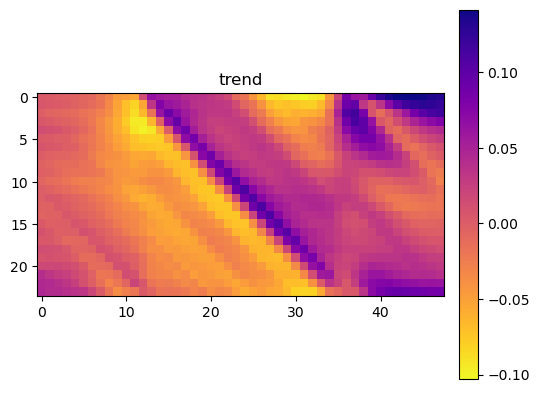

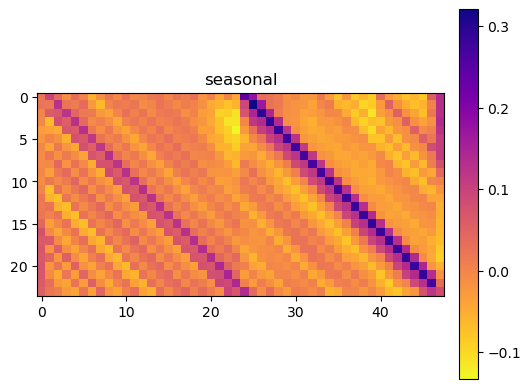

In [243]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()